<a href="https://colab.research.google.com/github/Risskr/Stock-App/blob/Simplified/StocksApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set Up**


In [1]:
# #refesh python script
# get_ipython().kernel.do_shutdown(restart=True)

# #Check GPUs
# !nvidia-smi

#load cudf to use GPUs for analysis
#%load_ext cudf.pandas

# import pandas
import pandas as pd
import datetime
import pickle
import numpy as np
from tqdm.notebook import tqdm

#!pip install tqdm==4.66.1

## Functions: Export/Import variables to My Drive

In [2]:
def import_variable(file_name):
  load_path = f"/content/drive/MyDrive/Colab Notebooks/{file_name}"

  try:
      variable = pd.read_parquet(load_path)

      print(f"Successfully loaded data from {load_path}")

  except FileNotFoundError:
      print(f"Error: The file was not found at {load_path}")
  except Exception as e:
      print(f"An error occurred while loading the file: {e}")
  return variable

# #run this funciton with this line
# x = import_variable("testing2_2025-05-22 19:07:29.595379.parquet")

In [ ]:
def export_variable(variable_name, file_name):

  now = datetime.datetime.now()

  save_path = f"/content/drive/MyDrive/Colab Notebooks/{file_name}_{now}.parquet"

  try:
      variable_name.to_parquet(save_path)
      print(f"Successfully saved the variable to {save_path}")
  except Exception as e:
      print(f"An error occurred while saving the file: {e}")
  return

# # use this line to run the function
# export_variable(lagged_correlations, "lagged_correlation")

# **Examples**

## Example how to locate in dataframes and in sereies

In [ ]:
# GOOGDailyClose_Series = GOOGDailyClose['close']

#Dataframe example
# x = GOOGDailyClose.loc[('GOOG', 2020, 1, 2), 'close']
# print(x)

#Series Example
# y = GOOGDailyClose_Series.loc[('GOOG', 2020, 1, 2)]
# print(y)

## Example graph

In [ ]:
# # from matplotlib import pyplot as plt
# # GOOGDailyClose['close'].plot(kind='line', figsize=(8, 4), title='close')
# # plt.gca().spines[['top', 'right']].set_visible(False)

# from matplotlib import pyplot as plt

# # Create the plot for GOOGDailyClose
# ax = GOOGDailyClose['close'].plot(kind='line', figsize=(8, 4), title='Closing Stock Prices')

# # Add the plot for MSFTDailyClose to the same axes
# MSFTDailyClose['close'].plot(kind='line', ax=ax)

# # Hide the top and right spines
# plt.gca().spines[['top', 'right']].set_visible(False)

# # Add a legend to distinguish the lines
# plt.legend(['GOOG', 'MSFT'])

## Example Call Function from another file
Eample Call Correlation_Coefficient function from another My Drive file

In [ ]:
# %run "/content/drive/My Drive/Colab Notebooks/Correlation_Coefficient.ipynb"

# Correlation_Coefficient(GOOGDailyClose, MSFTDaily Close)


# **Get Stock Data**

## Function: Download Stock Data to My Drive

In [ ]:
def DownloadStockData():
  #Download the stock data
  !if [ ! -f "usa_stocks_30m.parquet" ]; then curl https://storage.googleapis.com/rapidsai/colab-data/usa_stocks_30m.parquet -o usa_stocks_30m.parquet; else echo "usa_stocks_30m.parquet found"; fi

  #move the stock data to my Drive
  !mv usa_stocks_30m.parquet "/content/drive/MyDrive/Colab Notebooks"

## Function: Import Stock Data from My Drive

In [ ]:
def ImportStockData():
  # Import the stock data from My Drive
  # Define nasdaq_stocks as the stock data
  # Specify the full path to the file in your Google Drive
  nasdaq_stocks = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/usa_stocks_30m.parquet")
  return nasdaq_stocks

# #import Stock data from MyDrive
# nasdaq_stocks = ImportStockData()

## Function: Manipulate raw stock data for correlation funciton

In [ ]:
def ManipulateStockData(nasdaq_stocks):
  #add year, month, and day columns
  #df[["year", "week", "day"]] = df.datetime.dt.isocalendar()
  nasdaq_stocks["year"] = nasdaq_stocks.datetime.dt.year
  nasdaq_stocks["month"] = nasdaq_stocks.datetime.dt.month
  nasdaq_stocks["day"] = nasdaq_stocks.datetime.dt.day

  # Filter the DataFrame based on the 'year' column
  stock_TimeFiltered = nasdaq_stocks.loc[nasdaq_stocks['year'] >= 2023]

  #stock_TimeFiltered.info()
  #stock_TimeFiltered.head()

  #aggregate data by ticker, month, day, closing cost.
  stock_TimeFiltered_aggregated_close = stock_TimeFiltered.groupby(["ticker", "year", "month", "day"]).agg({"close": "last"})

  #stock_TimeFiltered_aggregated_close.info()
  #stock_TimeFiltered_aggregated_close.head()
  return stock_TimeFiltered_aggregated_close

# #Manipulate the raw stock data for my correlation function
# stock_TimeFiltered_aggregated_close = ManipulateStockData(nasdaq_stocks)

# **Correlation Coefficent funtions**

## Function: Correlation_Coefficient with Lag for two stocks

In [ ]:
# Correlation_Coefficient Function with Lag
# Using the Pearson correlation coefficient to determine correlation between two stocks with a lag

def Correlation_Coefficient_Lag(StockA, StockB, k=0):
  # Calculate the correlation between the 'close' columns with a lag
  StockA_series = StockA['close'].droplevel('ticker')
  StockB_series = StockB['close'].droplevel('ticker')

  # Apply the lag to StockB
  # Shift the StockB series down by k periods.
  # Positive k shifts data points forward, filling early entries with NaN.
  # Negative k shifts data points backward, filling late entries with NaN.
  StockB_lagged = StockB_series.shift(k)

  # Calculate the correlation between the original StockA and the lagged StockB
  # The .corr() method automatically handles NaN values by excluding them
  correlation = StockA_series.corr(StockB_lagged)

  return correlation

# # Example usage with a lag of k=1 day
# correlation_value_lag1 = Correlation_Coefficient_Lag(GOOGDailyClose, MSFTDailyClose, k=1)
# print(f"The Pearson correlation coefficient between GOOG and MSFT with a 1-day lag on MSFT is: {correlation_value_lag1}")

# # Example usage with a lag of k=-1 day
# correlation_value_lag_neg1 = Correlation_Coefficient_Lag(GOOGDailyClose, MSFTDailyClose, k=-1)
# print(f"The Pearson correlation coefficient between GOOG and MSFT with a -1-day lag on MSFT is: {correlation_value_lag_neg1}")

# # Example usage with no lag (k=0)
# correlation_value_lag0 = Correlation_Coefficient_Lag(GOOGDailyClose, MSFTDailyClose, k=0)
# print(f"The Pearson correlation coefficient between GOOG and MSFT with no lag is: {correlation_value_lag0}")

## Function: Sample GOOG and MSFT Correlation

In [ ]:
def GOOG_MSFT():
  # Access the 'ticker' level from the index for filtering
  GOOGDailyClose = stock_TimeFiltered_aggregated_close.loc[stock_TimeFiltered_aggregated_close.index.get_level_values('ticker') == "GOOG"]
  MSFTDailyClose = stock_TimeFiltered_aggregated_close.loc[stock_TimeFiltered_aggregated_close.index.get_level_values('ticker') == "MSFT"]

  GOOGDailyClose.info()
  GOOGDailyClose.head()

# Correlation_Coefficient Function
# Using the Pearson correlation coefficient to determine correlation between two stocks

def Correlation_Coefficient_testing(StockA, StockB):
  # Calculate the correlation between the 'close' columns
  StockA = StockA['close'].droplevel('ticker')
  StockB = StockB['close'].droplevel('ticker')
  correlation = StockA.corr(StockB)
  return correlation

  correlation_value = Correlation_Coefficient_testing(GOOGDailyClose, MSFTDailyClose)
  print(f"The Pearson correlation coefficient between GOOG and MSFT is: {correlation_value}")

## Function: Correlation Coeficient for entire stock data set

In [ ]:
def calculate_lagged_correlation(df, end_date, lag_days=1):
  # import pandas as pd
  # import numpy as np
  # from tqdm.notebook import tqdm # Import tqdm
  """
  Calculates the pairwise Pearson correlation coefficient between all stocks
  in a DataFrame for a specified 6-month period with a given lag.

  Args:
    df: DataFrame with a MultiIndex (ticker, year, month, day) and 'close' column.
    end_date: The end date (inclusive) of the 6-month period as a string 'YYYY-MM-DD'.
    lag_days: The number of days to lag the second stock's data.

  Returns:
    A pandas DataFrame containing the pairwise correlation coefficients.
  """
  # Convert end_date to datetime object
  end_datetime = pd.to_datetime(end_date)

  # Calculate the start date for the 6-month period
  start_datetime = end_datetime - pd.DateOffset(months=6)

  # Filter the DataFrame for the specified date range
  # We need to create a datetime column from the index to filter
  df['datetime'] = pd.to_datetime(df.index.get_level_values('year').astype(str) + '-' +
                                   df.index.get_level_values('month').astype(str) + '-' +
                                   df.index.get_level_values('day').astype(str))
  filtered_df = df[(df['datetime'] >= start_datetime) & (df['datetime'] <= end_datetime)]
  filtered_df = filtered_df.drop(columns=['datetime']) # Drop the temporary datetime column


  # Get unique tickers in the filtered data
  tickers = filtered_df.index.get_level_values('ticker').unique()

  # Create an empty DataFrame to store correlation results
  correlation_matrix = pd.DataFrame(index=tickers, columns=tickers, dtype=float)

  # Iterate through all pairs of tickers with a progress bar
  for ticker_a in tqdm(tickers, desc="Calculating correlations"): # Add tqdm here

    # Extract data for each ticker
    stock_a_data = filtered_df.loc[ticker_a, 'close']

    for ticker_b in tickers:
      if ticker_a != ticker_b:
        # Extract data for each ticker
        stock_b_data = filtered_df.loc[ticker_b, 'close']

        # Align the dataframes based on the date index
        aligned_data = pd.merge(stock_a_data.reset_index(), stock_b_data.reset_index(),
                                on=['year', 'month', 'day'], how='inner', suffixes=('_A', '_B'))
        aligned_data['datetime'] = pd.to_datetime(aligned_data['year'].astype(str) + '-' +
                                                  aligned_data['month'].astype(str) + '-' +
                                                  aligned_data['day'].astype(str))
        aligned_data = aligned_data.set_index('datetime').sort_index()

        # Apply the lag to stock_b_data
        lagged_stock_b_data = aligned_data['close_B'].shift(lag_days)

        # Calculate correlation, dropping NaN values
        correlation = aligned_data['close_A'].corr(lagged_stock_b_data)

        # Store the correlation in the matrix
        correlation_matrix.loc[ticker_a, ticker_b] = correlation

  return correlation_matrix

# Example usage:
# Assuming 'stock_TimeFiltered_aggregated_close' is your aggregated stock data
# and you want to calculate correlations ending on '2023-12-31' with a 1-day lag.
# Replace 'stock_TimeFiltered_aggregated_close' with the actual name of your DataFrame.
# end_date = '2023-12-31'
# lagged_correlations = calculate_pairwise_lagged_correlation(stock_TimeFiltered_aggregated_close, end_date, lag_days=1)

# Display the correlation matrix
# print(lagged_correlations)

# To access the correlation between specific stocks, e.g., GOOG and MSFT:
# print(lagged_correlations.loc['GOOG', 'MSFT'])

# #enter end date and run correlation function on entire stock data. This will take a couple of hours
# end_date = '2023-12-31'
# lagged_correlations = calculate_lagged_correlation(stock_TimeFiltered_aggregated_close, end_date, lag_days=1)

# **Run Fucntions**

In [3]:

# import correlation data from entire stock data that I saved off earlier on MyDrive
sixMonth_correlation_data = import_variable("6month_correlation_data.parquet")

Successfully loaded data from /content/drive/MyDrive/Colab Notebooks/6month_correlation_data.parquet


In [6]:
#sixMonth_correlation_data.head()

In [ ]:
# groups the data and adds coefficient of determination

import pandas as pd

def analyze_correlations(correlation_df):
  """

  Args:
    correlation_df: A pandas DataFrame where both index and columns are tickers
                    representing pairwise correlation coefficients.

  Returns:
    A pandas DataFrame with ticker as the index and columns for ticker_b,
    correlation, and coefficient of determination.
  """
  analyzed_data = []

  for ticker_a in correlation_df.index:
    # Extract correlations for ticker_a against all other tickers
    ticker_a_correlations = correlation_df.loc[ticker_a].drop(ticker_a) # Drop self-correlation

    for ticker_b, correlation in ticker_a_correlations.items():
      # Calculate the coefficient of determination (R-squared)
      coefficient_of_determination = correlation**2

      analyzed_data.append({
          'ticker_a': ticker_a,
          'ticker_b': ticker_b,
          'correlation': correlation,
          'coefficient_of_determination': coefficient_of_determination
      })

  # Create a new DataFrame
  analyzed_df = pd.DataFrame(analyzed_data)

  # Set the index to ticker_a and remove the ticker_a column
  analyzed_df = analyzed_df.set_index('ticker_a')

  return analyzed_df

# Analyze the sixMonth_correlation_data
grouped_correlation_data = analyze_correlations(sixMonth_correlation_data)

# Display the first few rows of the new DataFrame
print(grouped_correlation_data.head())


         ticker_b  correlation  coefficient_of_determination
ticker_a                                                    
A             AAL     0.436758                      0.190758
A            AAPL     0.757819                      0.574290
A            ABBV     0.288543                      0.083257
A            ABNB     0.607573                      0.369145
A             ABT     0.809978                      0.656064


In [ ]:
# Filter for only the top correlations

# Create a dictionary to store the filtered data for each ticker
filtered_data_dict = {}

# Iterate through each unique ticker in the index
for ticker_a, group_df in grouped_correlation_data.groupby(level=0):
    # Calculate the absolute correlation for the current ticker group
    group_df['abs_correlation'] = group_df['correlation'].abs()

    # Find the maximum absolute correlation for this ticker
    max_abs_correlation = group_df['abs_correlation'].max()

    # Define the threshold for keeping correlations (within 10% of the max)
    threshold = max_abs_correlation * 0.90  # Keep correlations >= 90% of the max

    # Filter the rows within the current ticker group based on the threshold
    filtered_group_df_threshold = group_df[group_df['abs_correlation'] >= threshold].copy()

    # Determine the final filtered DataFrame based on the number of rows
    if len(filtered_group_df_threshold) < 5:
        # If less than 5 rows after threshold filtering, get the top 5 based on absolute correlation
        # Sort by absolute correlation in descending order and take the top 5
        filtered_group_df = group_df.sort_values(by='abs_correlation', ascending=False).head(5).copy()
    elif len(filtered_group_df_threshold) > 20:
        # If more than 20 rows after threshold filtering, get the top 20 based on absolute correlation
        # Sort the threshold-filtered data and take the top 20
        filtered_group_df = filtered_group_df_threshold.sort_values(by='abs_correlation', ascending=False).head(20).copy()
    else:
        # If between 5 and 20 rows (inclusive) after threshold filtering, use the threshold-filtered result
        filtered_group_df = filtered_group_df_threshold

    # Remove the temporary 'abs_correlation' column from the final filtered DataFrame
    filtered_group_df = filtered_group_df.drop(columns=['abs_correlation'])

    # Store the final filtered DataFrame for this ticker
    filtered_data_dict[ticker_a] = filtered_group_df

# Concatenate the filtered DataFrames for all tickers back into a single DataFrame
# We'll call this new DataFrame 'most_correlated_stocks'
most_correlated_stocks = pd.concat(filtered_data_dict.values())

# Display the head of the new DataFrame to see the result
# print(most_correlated_stocks.head())

# You can also access the filtered data for a specific ticker, e.g., 'GOOG'
print(most_correlated_stocks.loc['AAPL']) # Example: Display filtered data for AAPL

         ticker_b  correlation  coefficient_of_determination
ticker_a                                                    
AAPL         BALL     0.917978                      0.842683
AAPL         EQIX     0.881262                      0.776624
AAPL         MPWR     0.878269                      0.771357
AAPL         ASML     0.877733                      0.770416
AAPL         SPGI     0.874539                      0.764819
AAPL         DDOG     0.874249                      0.764312
AAPL          MDB     0.865554                      0.749184
AAPL          XYL     0.864476                      0.747319
AAPL          MCO     0.863528                      0.745680
AAPL            C     0.858869                      0.737656
AAPL          CCI     0.858693                      0.737354
AAPL          SNA     0.854893                      0.730842
AAPL          ROP     0.853958                      0.729245
AAPL          HWM     0.853443                      0.728365
AAPL          AOS     0.

In [ ]:
# Calculate the minimum and maximum correlation for each ticker_a
min_max_correlations = most_correlated_stocks.groupby('ticker_a')['correlation'].agg(['min', 'max'])

# Define a function to normalize the correlation value with inverse scaling
def normalize_correlation_inverse(row):
    ticker_a = row.name  # Get the ticker_a from the index
    correlation = row['correlation']
    min_corr = min_max_correlations.loc[ticker_a, 'min']
    max_corr = min_max_correlations.loc[ticker_a, 'max']

    # Avoid division by zero if all correlations for a ticker are the same
    if max_corr == min_corr:
        return 0.0  # Or handle as appropriate (e.g., return a fixed value)

    # Normalize the correlation value to a range [1, 0] where min_corr maps to 1 and max_corr maps to 0
    # The formula for inverse scaling from [a, b] to [c, d] is:
    # normalized_value = d + (value - a) * (c - d) / (b - a)
    # Here, value = correlation, a = min_corr, b = max_corr, c = 1, d = 0
    normalized_value = 0 + (correlation - min_corr) * (1 - 0) / (max_corr - min_corr)
    # Now, we want min_corr to be 1 and max_corr to be 0.
    # So, we need to invert the normalized_value from [0, 1] to [1, 0].
    # This can be done with 1 - normalized_value
    orbital_radius = 1 - normalized_value

    return orbital_radius

# Apply the normalization function to create the new column 'Orbital Radius'
most_correlated_stocks['Orbital Radius'] = most_correlated_stocks.apply(normalize_correlation_inverse, axis=1)

# Display the dataframe with the new column
# print(most_correlated_stocks.head())
print(most_correlated_stocks.loc['AAPL'])

         ticker_b  correlation  coefficient_of_determination  Orbital Radius
ticker_a                                                                    
AAPL         BALL     0.917978                      0.842683        0.000000
AAPL         EQIX     0.881262                      0.776624        0.458541
AAPL         MPWR     0.878269                      0.771357        0.495923
AAPL         ASML     0.877733                      0.770416        0.502616
AAPL         SPGI     0.874539                      0.764819        0.542506
AAPL         DDOG     0.874249                      0.764312        0.546127
AAPL          MDB     0.865554                      0.749184        0.654724
AAPL          XYL     0.864476                      0.747319        0.668188
AAPL          MCO     0.863528                      0.745680        0.680035
AAPL            C     0.858869                      0.737656        0.738218
AAPL          CCI     0.858693                      0.737354        0.740412

In [ ]:
# prompt: Add a column to the dataframe ‘most_correlated_stocks’ The code will iterates through ticker_an and normalizes the coefficient_of_determination value using all of the coefficient_of_determinations for each ticker_b. This new column will be called ‘Planet Radius’

# Calculate the minimum and maximum coefficient of determination for each ticker_a
min_max_coefficient = most_correlated_stocks.groupby('ticker_a')['coefficient_of_determination'].agg(['min', 'max'])

# Define a function to normalize the coefficient of determination value
def normalize_coefficient(row):
    ticker_a = row.name  # Get the ticker_a from the index
    coefficient = row['coefficient_of_determination']
    min_coeff = min_max_coefficient.loc[ticker_a, 'min']
    max_coeff = min_max_coefficient.loc[ticker_a, 'max']

    # Avoid division by zero if all coefficients for a ticker are the same
    if max_coeff == min_coeff:
        return 0.0  # Or handle as appropriate

    # Normalize the coefficient of determination value to a range [0, 1]
    normalized_value = (coefficient - min_coeff) / (max_coeff - min_coeff)
    return normalized_value

# Apply the normalization function to create the new column 'Planet Radius'
most_correlated_stocks['Planet Radius'] = most_correlated_stocks.apply(normalize_coefficient, axis=1)

# Display the dataframe with the new column
# print(most_correlated_stocks.head())
print(most_correlated_stocks.loc['AAPL'])

         ticker_b  correlation  coefficient_of_determination  Orbital Radius  \
ticker_a                                                                       
AAPL         BALL     0.917978                      0.842683        0.000000   
AAPL         EQIX     0.881262                      0.776624        0.458541   
AAPL         MPWR     0.878269                      0.771357        0.495923   
AAPL         ASML     0.877733                      0.770416        0.502616   
AAPL         SPGI     0.874539                      0.764819        0.542506   
AAPL         DDOG     0.874249                      0.764312        0.546127   
AAPL          MDB     0.865554                      0.749184        0.654724   
AAPL          XYL     0.864476                      0.747319        0.668188   
AAPL          MCO     0.863528                      0.745680        0.680035   
AAPL            C     0.858869                      0.737656        0.738218   
AAPL          CCI     0.858693          

In [ ]:
# Reset the index to turn the 'ticker_a' index level into a column
most_correlated_stocks_long = most_correlated_stocks.reset_index()

# Rename 'ticker_a' to 'source' and 'ticker_b' to 'target' for clarity in network context
most_correlated_stocks_long = most_correlated_stocks_long.rename(columns={'ticker_a': 'source', 'ticker_b': 'target'})

# Display the head of the long format DataFrame
print(most_correlated_stocks_long.head())

  source target  correlation  coefficient_of_determination  Orbital Radius  \
0      A     BA     0.938178                      0.880178        0.000000   
1      A    JPM     0.933544                      0.871504        0.104285   
2      A    SHW     0.932902                      0.870305        0.118736   
3      A   NTRS     0.932325                      0.869230        0.131712   
4      A   HBAN     0.931452                      0.867603        0.151358   

   Planet Radius  
0       1.000000  
1       0.893449  
2       0.878726  
3       0.865514  
4       0.845526  


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import pandas as pd

def plot_ticker_network_visual(correlated_data, target_ticker):
    """
    Plots a network graph for a specific ticker and its most correlated partners,
    where distance is based on 'Orbital Radius', node size on 'Planet Radius',
    and edge labels are correlations as percentages.

    Args:
      correlated_data: DataFrame with columns 'source', 'target', 'correlation',
                       'Orbital Radius', 'Planet Radius'.
      target_ticker: The ticker for which to generate the network graph.
    """
    # Filter the data to include only connections where the target ticker is the source
    ticker_connections = correlated_data[correlated_data['source'] == target_ticker].copy()

    # Handle cases where there are no connections found after filtering
    if ticker_connections.empty:
        print(f"No connections found for ticker {target_ticker} as the source within the provided data.")
        return

    # Create a graph
    G = nx.from_pandas_edgelist(ticker_connections,
                                'source', 'target',
                                ['correlation', 'Orbital Radius', 'Planet Radius'])

    # Customize graph visualization
    plt.figure(figsize=(12, 10))

    # --- Positioning based on 'Orbital Radius' ---
    # We need to create a dictionary of positions where the target_ticker is at the center (0,0)
    # and other nodes are placed based on their 'Orbital Radius'.
    # A simple approach is to place them on a circle with the orbital radius.
    pos = {}
    pos[target_ticker] = (0, 0) # Center the target ticker

    # Place other nodes on a circle based on their orbital radius
    num_connections = len(ticker_connections)
    for i, row in ticker_connections.iterrows():
        target = row['target']
        orbital_radius = row['Orbital Radius']
        # Add the minimum distance to the orbital radius
        min_distance = 0.3
        orbital_radius = orbital_radius + min_distance

        # Distribute nodes around a circle
        angle = 2 * np.pi * i / num_connections
        x = orbital_radius * np.cos(angle)
        y = orbital_radius * np.sin(angle)
        pos[target] = (x, y)

    # --- Node Sizes based on 'Planet Radius' ---
    # Create a dictionary of node sizes
    node_sizes = {}
    node_sizes[target_ticker] = 1000 # Set a fixed size for the central node
    for i, row in ticker_connections.iterrows():
        target = row['target']
        planet_radius = row['Planet Radius']
        # Scale planet radius to a reasonable node size range (e.g., 300 to 800)
        # Assuming 'Planet Radius' is normalized between 0 and 1
        scaled_size = 300 + (planet_radius * 500)
        node_sizes[target] = scaled_size


    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=[node_sizes.get(node, 300) for node in G.nodes()], node_color='skyblue', alpha=0.9)

    # Draw edges and color based on correlation sign
    edge_colors = ['red' if data['correlation'] < 0 else 'green' for u, v, data in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=2)

    # Draw labels
    #nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_labels(G, pos, font_size=10)

    # --- Draw edge labels manually at the midpoint of the straight line ---
    edge_labels = {(u, v): data['correlation'] for u, v, data in G.edges(data=True)}
    formatted_edge_labels = {k: f'{v:.2%}' for k, v in edge_labels.items()} # Format as percentage

    for (u, v), label in formatted_edge_labels.items():
        # Get the positions of the connected nodes
        x1, y1 = pos[u]
        x2, y2 = pos[v]

        # Calculate the midpoint coordinates
        mid_x = (x1 + x2) / 2
        mid_y = (y1 + y2) / 2

        # Draw the text at the midpoint
        plt.text(mid_x, mid_y, label,
                 fontsize=8, color='black', ha='center', va='center',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))

    plt.title(f'Network for {target_ticker} and Most Correlated Partners')
    plt.axis('off') # Hide axes
    plt.show()

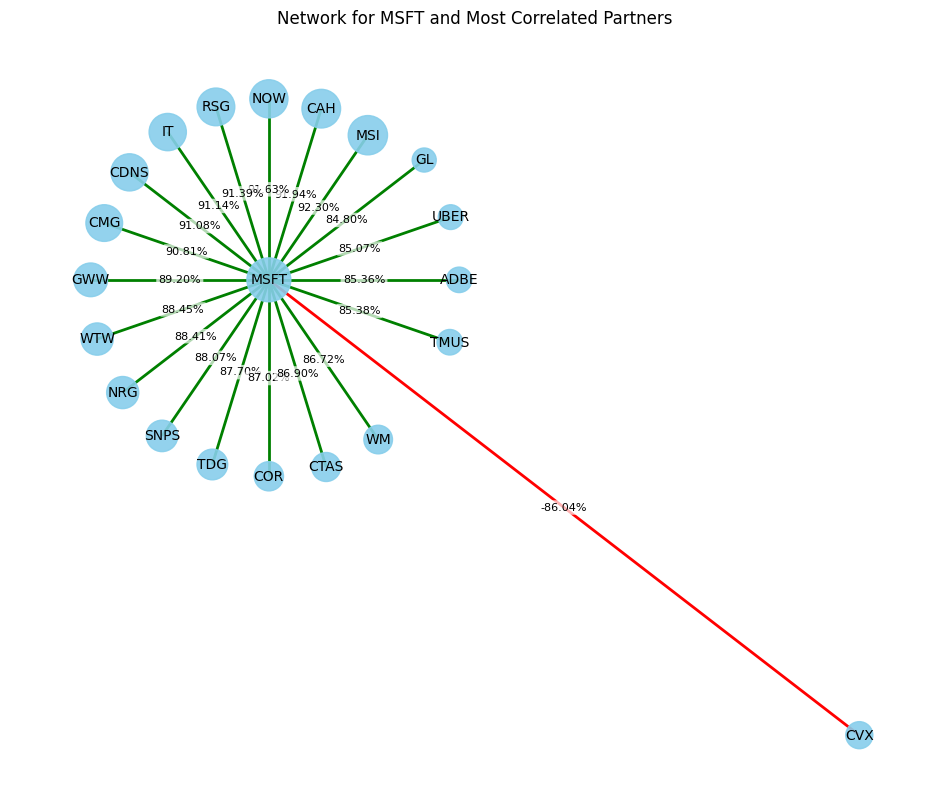

In [ ]:
# Example usage:
plot_ticker_network_visual(most_correlated_stocks_long, 'MSFT') # Replace 'AAPL' with the ticker you want to visualize